In [2]:
import sys
import os

# Add the root directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from weighted_model.fair_teacher_student_classifier import FairTeacherStudentClassifier
from weighted_model.teacher_student_classifier import TeacherStudentClassifier
from curriculum_models.curriculum_student_teacher import CurriculumStudentTeacher
from curriculum_models.weighted_curriculum_student_teacher import WeightedCurriculumStudentTeacher
from sklearn.linear_model import SGDClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from fairlearn.datasets import fetch_adult
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
np.random.seed(41) # Set seed for reproducibility

In [3]:
data = fetch_adult(as_frame=True)
df = data.frame
print(len(df))
df.head()


48842


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


race                class
Amer-Indian-Eskimo  <=50K    0.882979
                    >50K     0.117021
Asian-Pac-Islander  <=50K    0.730744
                    >50K     0.269256
Black               <=50K    0.879189
                    >50K     0.120811
Other               <=50K    0.876847
                    >50K     0.123153
White               <=50K    0.746013
                    >50K     0.253987
Name: proportion, dtype: float64


C:\Users\trdin\AppData\Local\Temp\ipykernel_16244\2974537177.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('race')['class'].value_counts(normalize=True))


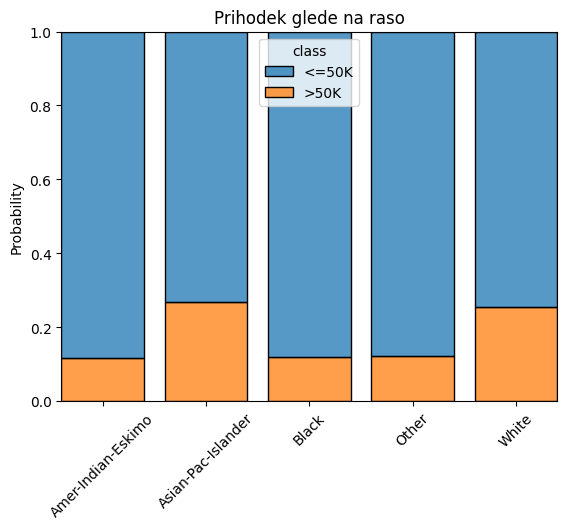

In [4]:
import matplotlib.pyplot as plt
print(df.groupby('race')['class'].value_counts(normalize=True))

sns.histplot(data=df, x='race', hue='class', stat='probability', multiple='fill', shrink=.8)
plt.title("Prihodek glede na raso")
plt.xticks(rotation=45)
plt.xlabel(None)
plt.show()

In [5]:
# Load dataset
data = fetch_adult(as_frame=True)
df = data.frame

# Preprocessing: Encode categorical variables
label_encoders = {}
for col in ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Features and labels
X = df.drop(columns=['class'])
y = (df['class'] == '>50K').astype(int)  # Binary target: 1 if >50K, else 0
z = df['race']  # Sensitive attribute

# Train-test split
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.2, random_state=42, stratify=y, shuffle=True)


In [6]:

def split_into_parts(X, y_prob, n_splits = 5):
    """Splits X and y into 5 equal parts and returns them as a list of (X_part, y_part)."""
    split_size = len(X) // n_splits
    
    # Convert probabilities to predictions
    y_pred = np.argmax(y_prob, axis=1)

    split_data = []
    for i in range(n_splits):
        start_idx = i * split_size
        end_idx = (i + 1) * split_size if i < n_splits - 1 else len(X)
        split_data.append((X[start_idx:end_idx], y_pred[start_idx:end_idx]))

    return split_data


In [7]:
import numpy as np
import pandas as pd

## TODO - Maybe we could teach the model only on easy data or only on hard data

## TODO - Partially Fit then test - then fit again with weights on misslassified samples

def split_into_difficulty_parts(X, y_prob, n_splits=5, ascending=False):
    """Splits X and y into 5 parts based on the highest prediction probability, 
    with the most difficult samples (lowest probability) getting split last.
    """
    split_size = len(X) // n_splits
    
    # Get the maximum probability and corresponding predicted class
    max_prob = np.max(y_prob, axis=1)  # Get highest probability for each sample
    y_pred = np.argmax(y_prob, axis=1)  # Get predicted class labels

    # Combine X (DataFrame), y_pred, and max_prob into a single DataFrame for sorting
    X_sorted = X.copy()  # Work with a copy to avoid modifying original
    X_sorted['y_pred'] = y_pred
    X_sorted['max_prob'] = max_prob
    
    # By default: Sort by the highest probability (descending order) - more confident predictions come first
    X_sorted = X_sorted.sort_values(by='max_prob', ascending=ascending)

    #print(X_sorted.head())    
    # Split the sorted data into n_splits parts
    split_data = []
    for i in range(n_splits):
        start_idx = i * split_size
        end_idx = (i + 1) * split_size if i < n_splits - 1 else len(X_sorted)
        split_X = X_sorted.iloc[start_idx:end_idx].drop(columns=['y_pred', 'max_prob'])  # Drop auxiliary columns
        #print(split_X.head())
        split_y_pred = X_sorted.iloc[start_idx:end_idx]['y_pred']
        split_data.append((split_X, split_y_pred))

    return split_data


In [8]:
def split_into_difficulty_parts_asc(X, y_prob, n_splits=5):
    return split_into_difficulty_parts(X, y_prob, n_splits, ascending=True)


In [9]:
import numpy as np
import pandas as pd

def split_by_race_and_confidence(X, y_prob, n_splits=5, ascending=False):
    """
    Splits X and y into groups based on race, orders races by their average prediction confidence,
    and sorts each race group by confidence.
    n_splits parameter is not used bu it is here for compatibility with other split functions.

    Returns:
        race_splits (dict): A dictionary where keys are race names and values are (X, y_pred) tuples.
        race_confidence (pd.Series): A Series showing the average confidence for each race.
    """
    # Get the maximum probability and corresponding predicted class
    max_prob = np.max(y_prob, axis=1)  # Get highest probability for each sample
    y_pred = np.argmax(y_prob, axis=1)  # Get predicted class labels

    # Add prediction data to X DataFrame
    X_sorted = X.copy()
    X_sorted['y_pred'] = y_pred
    X_sorted['max_prob'] = max_prob

    # Group by race
    race_groups = X_sorted.groupby("race")

    # Compute average confidence for each race
    race_confidence = race_groups["max_prob"].mean().sort_values(ascending=ascending)	

    # Store race-based splits
    race_splits = []
    for race in race_confidence.index:
        race_data = race_groups.get_group(race)
        
        # Drop auxiliary columns before returning
        split_X = race_data.drop(columns=['y_pred', 'max_prob'])
        split_y_pred = race_data['y_pred']
        
         # Append to the result list as a tuple
        race_splits.append((split_X, split_y_pred))

    return race_splits


In [10]:
def split_by_race_and_confidence_asc(X, y_prob, n_splits=5, ascending=True):
    return split_by_race_and_confidence(X, y_prob, n_splits=n_splits, ascending=True)

In [11]:
from sklearn.linear_model import Perceptron, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB

# TODO
# Experiment 
# Random forrest pa SGD 
# 
# CurriculumStudentTeacher  SGD  and MultinomialNB with different trasnform functions
fairness_curriculum_SGD = CurriculumStudentTeacher(teacher_type=RandomForestClassifier, student_type = SGDClassifier, transform_func= split_by_race_and_confidence, split_data=False)
fairness_curriculum_SGD_asc = CurriculumStudentTeacher(teacher_type=RandomForestClassifier, student_type = SGDClassifier, transform_func= split_by_race_and_confidence_asc, split_data=False)

# WeightedCurriculumStudentTeacher with different modes for sample weights calculation
weighted_curriculum_model_mode_0 = WeightedCurriculumStudentTeacher(teacher_type=RandomForestClassifier, student_type = SGDClassifier, transform_func= split_by_race_and_confidence , split_data=False)
weighted_curriculum_model_mode_1 = WeightedCurriculumStudentTeacher(teacher_type=RandomForestClassifier, student_type = SGDClassifier, transform_func= split_by_race_and_confidence , split_data=False)

# FairTeacherStudentClassifier the most succesfull clasifier from the previous experiments with weights
#TODO change teacher RandomForrest pa stundent SGD
fair_classifier_split_mode_1 = FairTeacherStudentClassifier(RandomForestClassifier, split_data=False)


# Multiple curriculum models for reference

curriculum_model = CurriculumStudentTeacher(teacher_type=RandomForestClassifier, student_type = SGDClassifier, transform_func= split_into_parts, split_data=False, n_splits=6)	

difficulty_based_model = CurriculumStudentTeacher(teacher_type=RandomForestClassifier, student_type = SGDClassifier, transform_func= split_into_difficulty_parts, split_data=False, n_splits=6)

diff_asc_model = CurriculumStudentTeacher(teacher_type=RandomForestClassifier, student_type = SGDClassifier, transform_func= split_into_difficulty_parts_asc, split_data=False, n_splits=6)

#Student Teacher models for reference
student_teacher = TeacherStudentClassifier(SGDClassifier, split_data=True)

#randomForrest for reference
rf_classifier = RandomForestClassifier()

#SGD for reference
sgd_model = SGDClassifier()


# Train classifiers
diff_asc_model.fit(X_train.copy(deep=False), y_train.copy(deep=False))

fairness_curriculum_SGD.fit(X_train.copy(deep=False), y_train.copy(deep=False))
fairness_curriculum_SGD_asc.fit(X_train.copy(deep=False), y_train.copy(deep=False))

weighted_curriculum_model_mode_0.fit(X_train.copy(deep=False), y_train.copy(deep=False), z_train.copy(deep=False), mode=0)
weighted_curriculum_model_mode_1.fit(X_train.copy(deep=False), y_train.copy(deep=False), z_train.copy(deep=False), mode=1)

fair_classifier_split_mode_1.fit(X_train.copy(deep=False), y_train.copy(deep=False), z_train.copy(deep=False), mode=1)


sgd_model.fit(X_train, y_train)
difficulty_based_model.fit(X_train, y_train)
curriculum_model.fit(X_train, y_train)
student_teacher.fit(X_train, y_train)
rf_classifier.fit(X_train, y_train)

# Predicitons with all the models 
curriculum_fairness_SGD_predictions = fairness_curriculum_SGD.predict(X_test)
curriculum_fairness_SGD_asc_predictions = fairness_curriculum_SGD_asc.predict(X_test)

weighted_curriculum_mode_0_predictions = weighted_curriculum_model_mode_0.predict(X_test)
weighted_curriculum_mode_1_predictions = weighted_curriculum_model_mode_1.predict(X_test)

fair_classifier_split_mode_1_predictions = fair_classifier_split_mode_1.predict(X_test)


diff_asc_model_predictions = diff_asc_model.predict(X_test)
curriculum_model_predictions = curriculum_model.predict(X_test)
difficulty_based_model_predictions = difficulty_based_model.predict(X_test)

SGD_model_predictions= sgd_model.predict(X_test)
student_teacher_predictions = student_teacher.predict(X_test)
rf_predictions = rf_classifier.predict(X_test)

Min accuracy group: 2
Min accuracy group: 2


{'Fair Curriculum Model SGD': 0.7809397072371789, 'Fair Curriculum Model SGD Asc': 0.7881052308322244, 'Fair Classifier Split Mode 1': 0.8620124884839799, 'Weighted Curriculum Mode 0': 0.7753096529839287, 'Weighted Curriculum Mode 1': 0.7799160610093152, 'diff_asc_model': 0.7948612959361244, 'Curriculum Model': 0.7844201044119152, 'SGD Model': 0.7962944006551336, 'Student Teacher Model': 0.789128877060088, 'Random Forest': 0.8599651960282526}


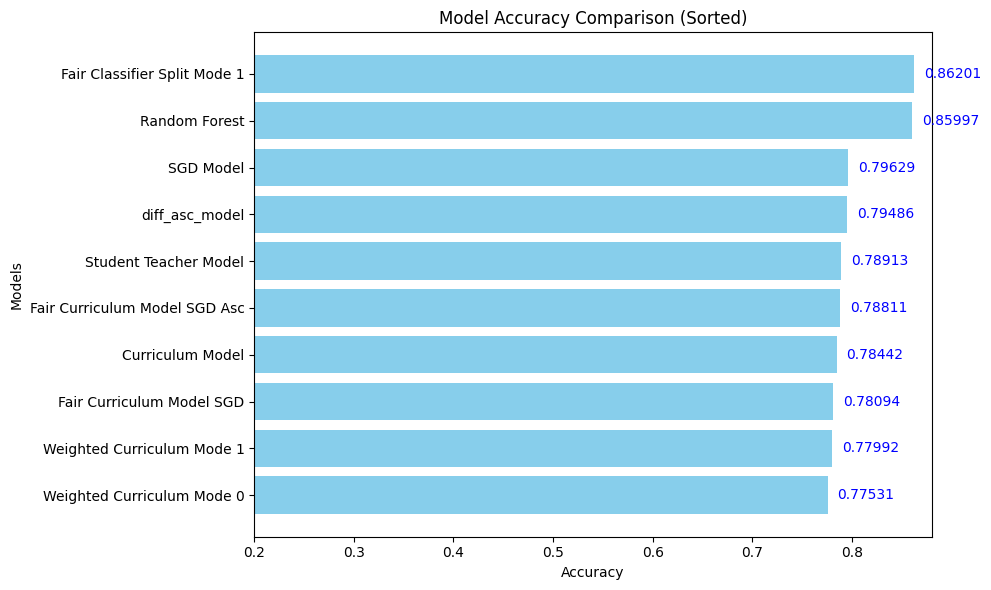

In [12]:
# Evaluate accuracy for each model
accuracies = {
    "Fair Curriculum Model SGD": accuracy_score(y_test,curriculum_fairness_SGD_predictions),
    "Fair Curriculum Model SGD Asc": accuracy_score(y_test,curriculum_fairness_SGD_asc_predictions),
    "Fair Classifier Split Mode 1": accuracy_score(y_test, fair_classifier_split_mode_1_predictions),
    "Weighted Curriculum Mode 0": accuracy_score(y_test, weighted_curriculum_mode_0_predictions),
    "Weighted Curriculum Mode 1": accuracy_score(y_test, weighted_curriculum_mode_1_predictions),
    "diff_asc_model": accuracy_score(y_test, diff_asc_model_predictions),
    "Curriculum Model": accuracy_score(y_test, curriculum_model_predictions),
    "SGD Model": accuracy_score(y_test, SGD_model_predictions),
    "Student Teacher Model": accuracy_score(y_test, student_teacher_predictions),
    "Random Forest": accuracy_score(y_test, rf_predictions),
}

print(accuracies)

# Sort models by accuracy
sorted_accuracies = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

# Prepare data for plotting
models = [item[0] for item in sorted_accuracies]
accuracy_values = [item[1] for item in sorted_accuracies]

# Plot the sorted accuracies
plt.figure(figsize=(10, 6))
plt.barh(models, accuracy_values, color="skyblue")
plt.xlabel("Accuracy")
plt.ylabel("Models")
plt.title("Model Accuracy Comparison (Sorted)")
plt.gca().invert_yaxis()  # Invert y-axis to show highest accuracy at the top
plt.xlim(0.2, 0.88)


# Annotate bars with accuracy values
for i, v in enumerate(accuracy_values):
    plt.text(v + 0.01, i, f"{v:.5f}", color='blue', va='center')

plt.tight_layout()
plt.show()


In [13]:
# Compare accuracy by race
results = {}
for group in np.unique(z_test):
    mask = (z_test == group)
    
    # Calculate accuracy for each model
    fair_curriculum_sgd_acc = accuracy_score(y_test[mask], curriculum_fairness_SGD_predictions[mask])
    fair_curriculum_sgd_asc_acc = accuracy_score(y_test[mask], curriculum_fairness_SGD_asc_predictions[mask])
    weighted_curriculum_mode_0_acc = accuracy_score(y_test[mask], weighted_curriculum_mode_0_predictions[mask])
    weighted_curriculum_mode_1_acc = accuracy_score(y_test[mask], weighted_curriculum_mode_1_predictions[mask])
    fair_classifier_split_mode_1_acc = accuracy_score(y_test[mask], fair_classifier_split_mode_1_predictions[mask])
    diff_asc_model_acc = accuracy_score(y_test[mask], diff_asc_model_predictions[mask])
    curriculum_model_acc = accuracy_score(y_test[mask], curriculum_model_predictions[mask])
    SGD_model_acc = accuracy_score(y_test[mask], SGD_model_predictions[mask])
    studet_teacher_acc = accuracy_score(y_test[mask], student_teacher_predictions[mask])
    rf_accuracy = accuracy_score(y_test[mask], rf_predictions[mask])

    # Add all model accuracies to the results dictionary
    results[label_encoders['race'].inverse_transform([group])[0]] = {
        "Fair Curriculum Model SGD": fair_curriculum_sgd_acc,
        "Fair Curriculum Model SGD Asc": fair_curriculum_sgd_asc_acc,
        "Weighted Curriculum Mode 0": weighted_curriculum_mode_0_acc,
        "Weighted Curriculum Mode 1": weighted_curriculum_mode_1_acc,
        "Fair Classifier Split Mode 1": fair_classifier_split_mode_1_acc,
        "Diff Asc Model": diff_asc_model_acc,
        "Curriculum Model": curriculum_model_acc,
        "SGD Model": SGD_model_acc,
        "Student Teacher": studet_teacher_acc,
        "Random Forest": rf_accuracy
    }

# Display results
results_df = pd.DataFrame(results).T
print(results_df)

                    Fair Curriculum Model SGD  Fair Curriculum Model SGD Asc  \
Amer-Indian-Eskimo                   0.875000                       0.885417   
Asian-Pac-Islander                   0.758842                       0.768489   
Black                                0.872934                       0.878099   
Other                                0.890244                       0.914634   
White                                0.768888                       0.775987   

                    Weighted Curriculum Mode 0  Weighted Curriculum Mode 1  \
Amer-Indian-Eskimo                    0.875000                    0.875000   
Asian-Pac-Islander                    0.752412                    0.758842   
Black                                 0.870868                    0.872934   
Other                                 0.890244                    0.890244   
White                                 0.762753                    0.767685   

                    Fair Classifier Split Mode 1  

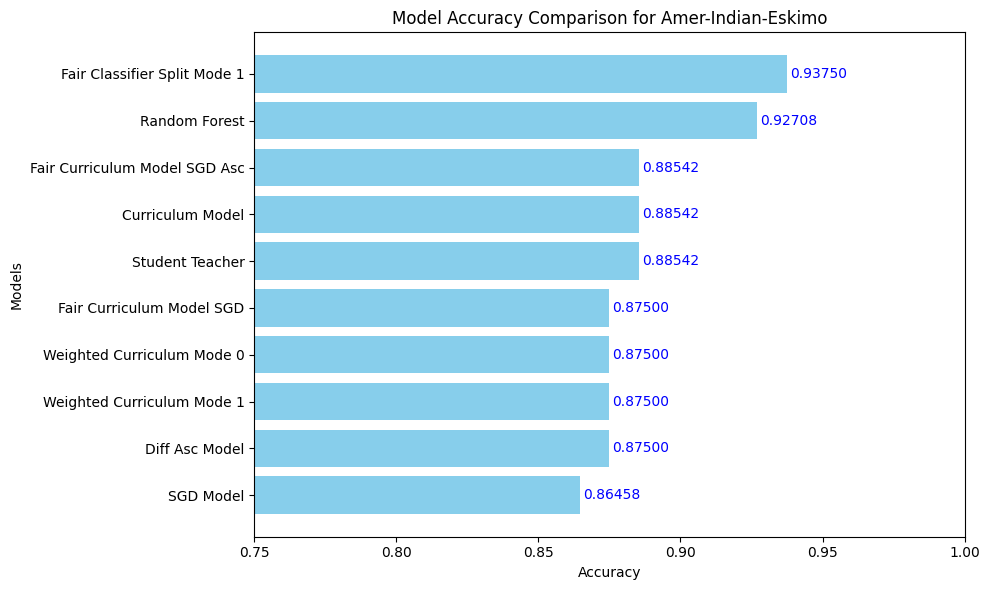

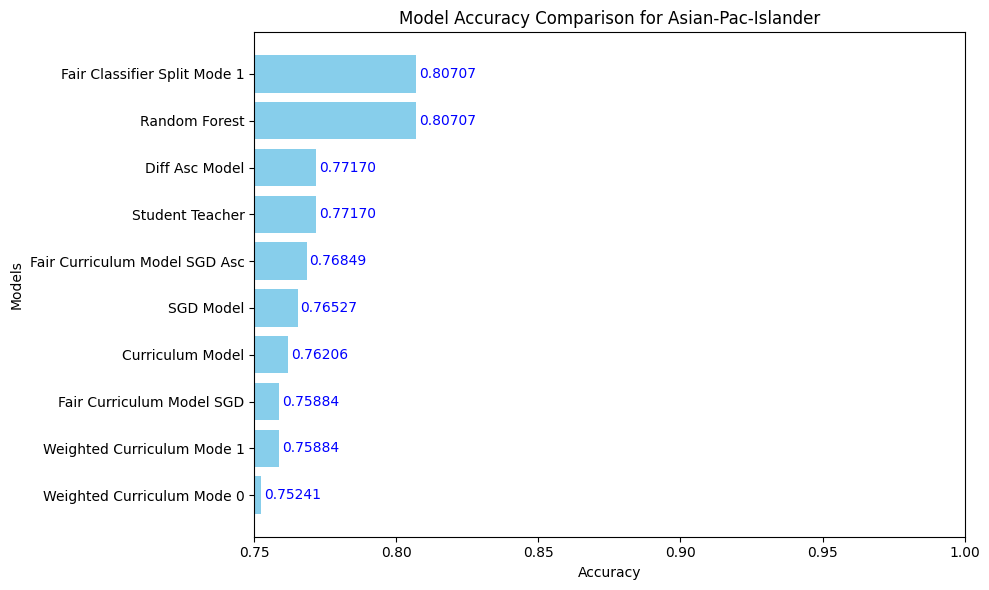

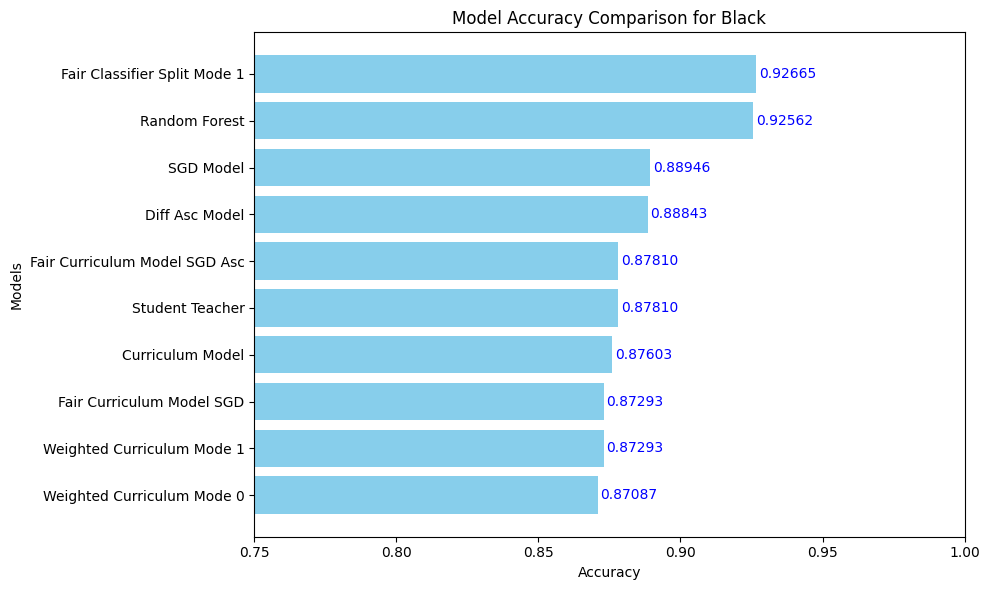

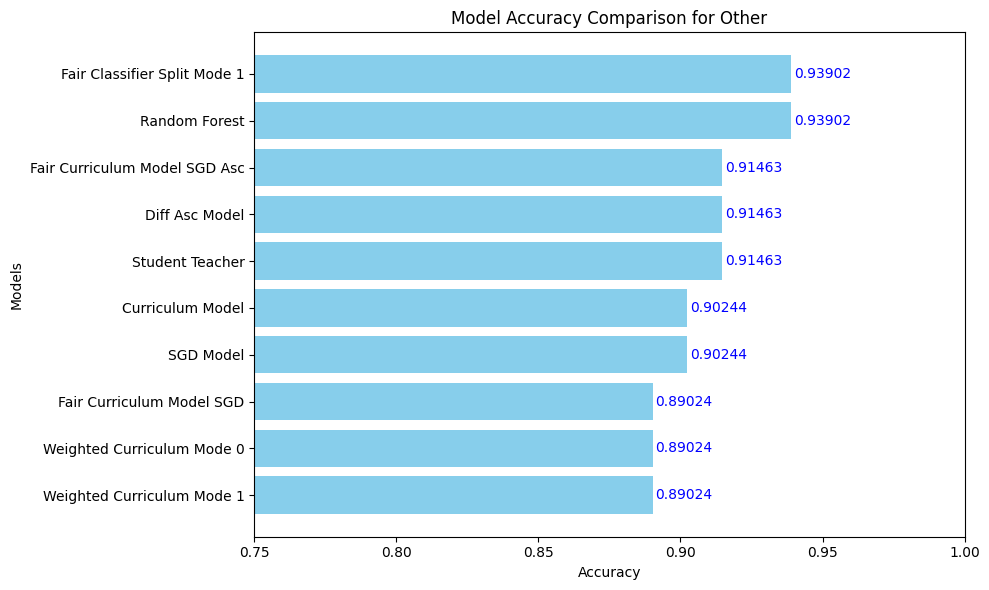

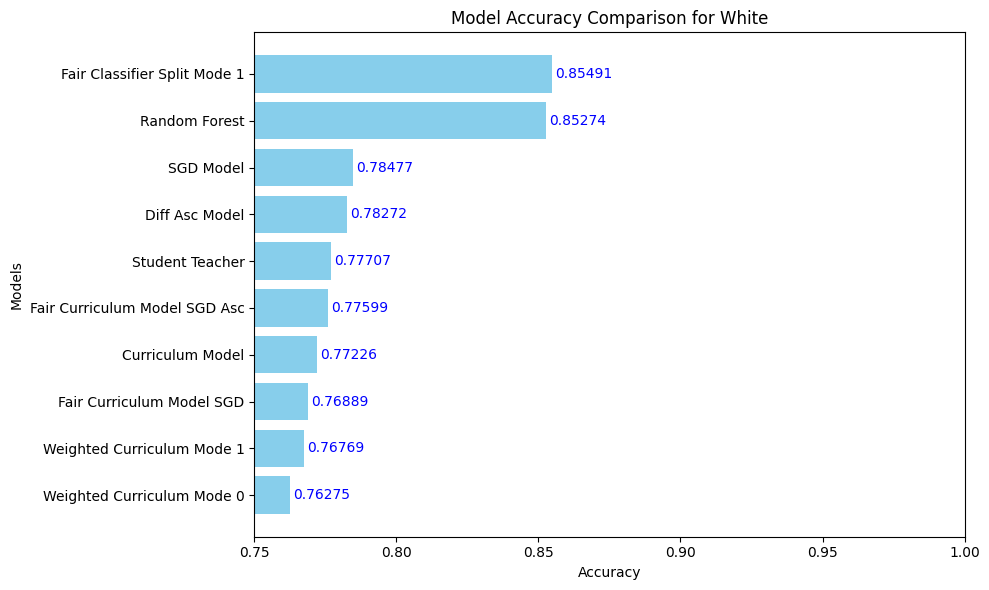

In [14]:
for race_group in results_df.index:
    # Get the accuracy values for this race group
    accuracies = results_df.loc[race_group]
    
    # Sort the accuracies in descending order
    accuracies_sorted = accuracies.sort_values(ascending=False)
    
    # Create the bar chart for this race group
    plt.figure(figsize=(10, 6))
    plt.barh(accuracies_sorted.index, accuracies_sorted.values, color="skyblue")
    plt.xlabel("Accuracy")
    plt.ylabel("Models")
    plt.title(f"Model Accuracy Comparison for {race_group}")
    plt.xlim(0.75, 1)  # Limiting accuracy between 0.8 and 0.9
    
    # Annotate bars with accuracy values
    for i, v in enumerate(accuracies_sorted.values):
        plt.text(v + 0.001, i, f"{v:.5f}", color='blue', va='center')

    # Invert y-axis to show the highest accuracy at the top
    plt.gca().invert_yaxis()
    
    # Display the plot
    plt.tight_layout()
    plt.show()

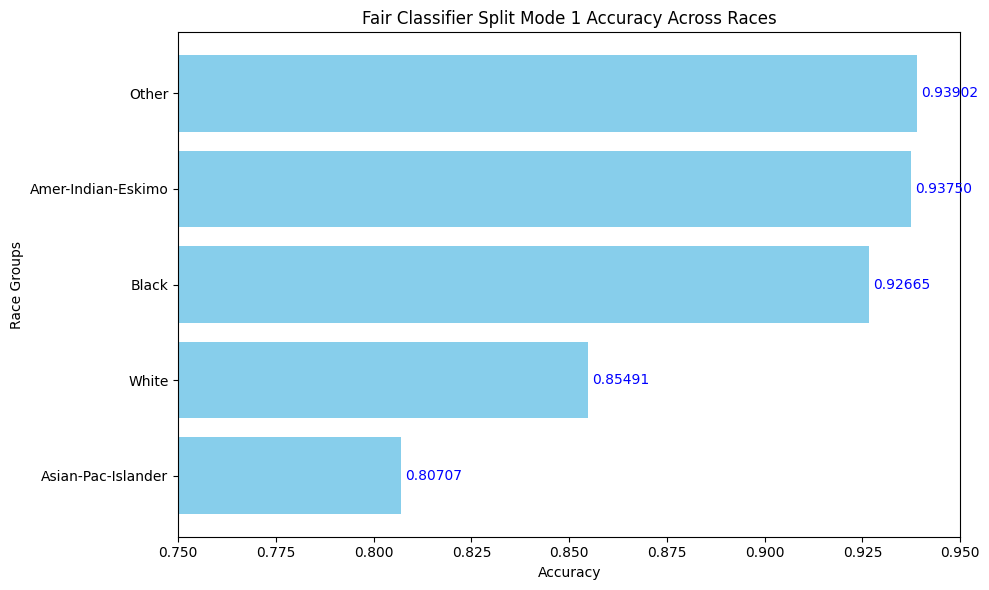

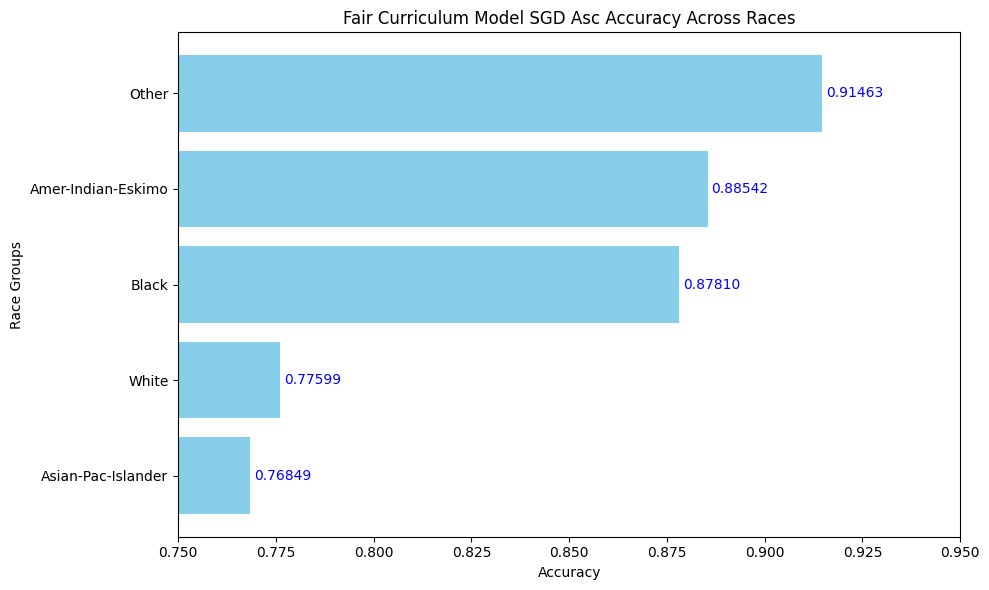

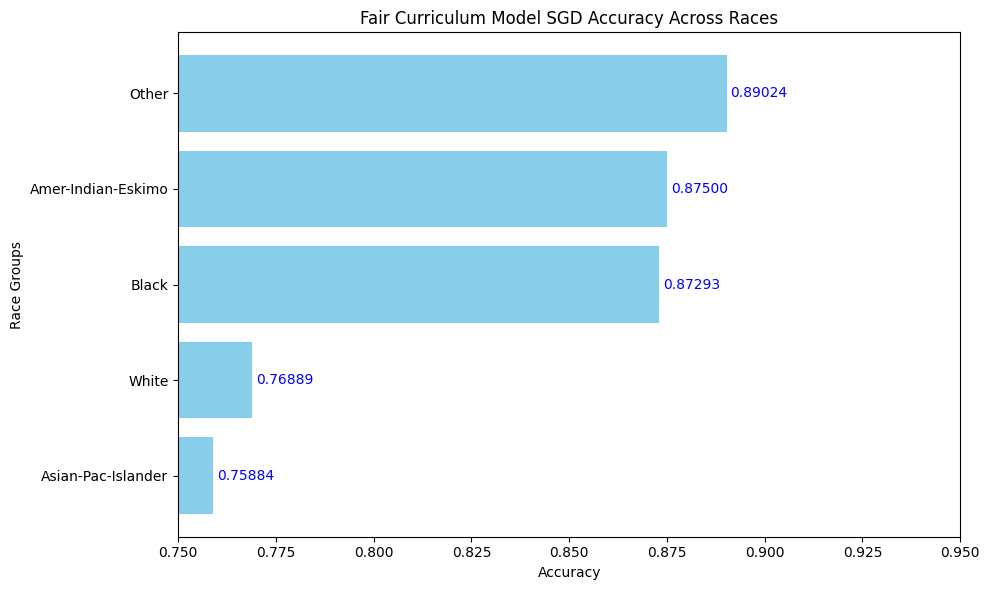

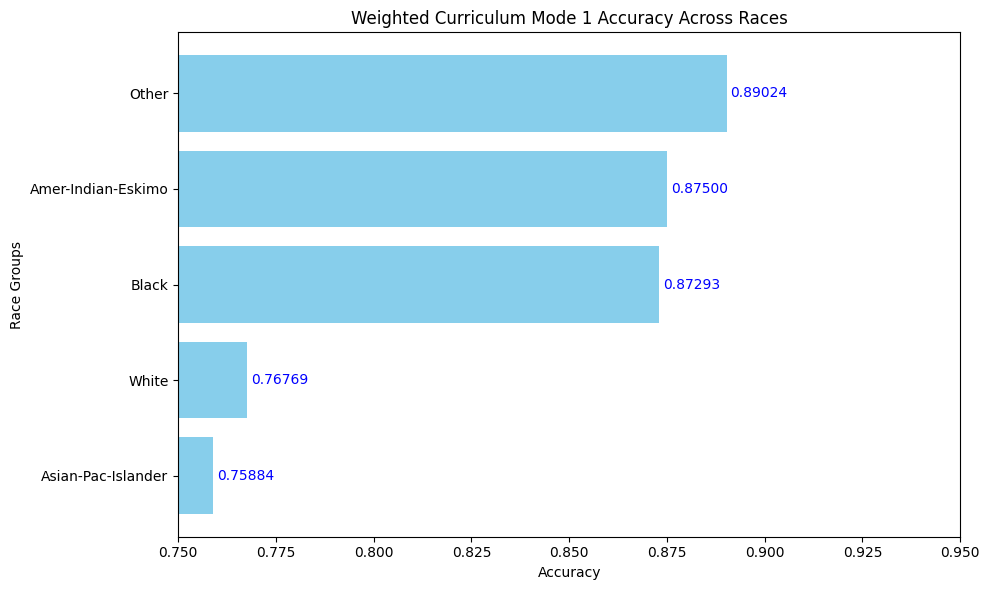

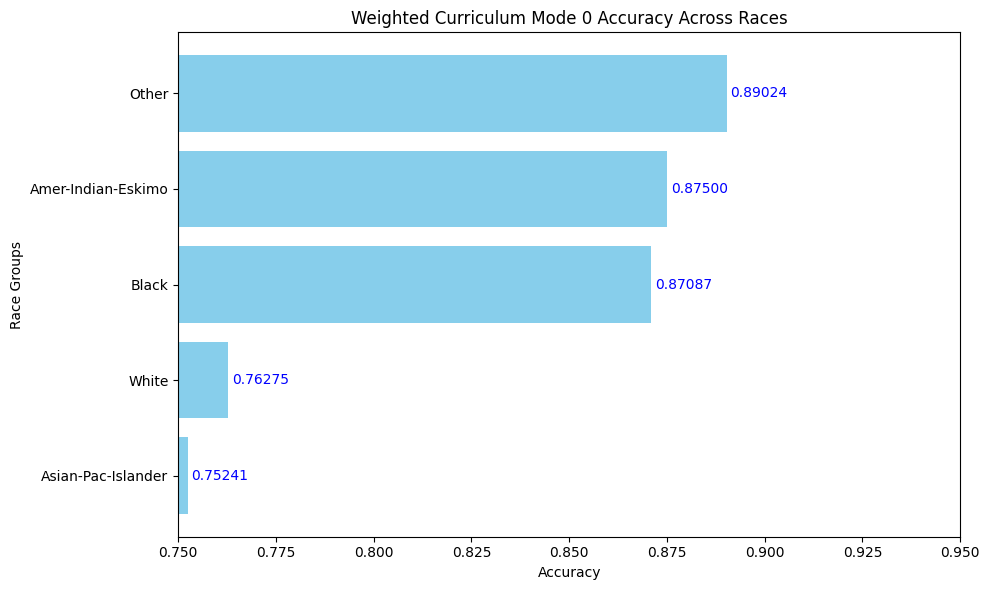

In [15]:
# Fairness models comparison, fairness by race

# Define the models to include
selected_models = [
    "Fair Curriculum Model SGD",
    "Weighted Curriculum Mode 0",
    "Weighted Curriculum Mode 1",
    "Fair Classifier Split Mode 1",
    "Fair Curriculum Model SGD Asc",
]

# Filter the accuracy dictionary to include only the selected models
filtered_accuracies = {model: accuracies[model] for model in selected_models}

# Sort the selected models by overall accuracy
sorted_accuracies = sorted(filtered_accuracies.items(), key=lambda x: x[1], reverse=True)

# Extract the sorted model names
sorted_models = [item[0] for item in sorted_accuracies]

# Plot accuracies by race for each selected model
for model in sorted_models:
    # Get the accuracies for this model across all races
    model_accuracies = results_df[model]
    
    # Sort the accuracies in descending order
    model_accuracies_sorted = model_accuracies.sort_values(ascending=False)
    
    # Create the bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(model_accuracies_sorted.index, model_accuracies_sorted.values, color="skyblue")
    plt.xlabel("Accuracy")
    plt.ylabel("Race Groups")
    plt.title(f"{model} Accuracy Across Races")
    plt.xlim(0.75, 0.95)  # Adjust accuracy range if needed

    # Annotate bars with accuracy values
    for i, v in enumerate(model_accuracies_sorted.values):
        plt.text(v + 0.001, i, f"{v:.5f}", color='blue', va='center')

    # Invert y-axis to show highest accuracy at the top
    plt.gca().invert_yaxis()

    # Display the plot
    plt.tight_layout()
    plt.show()

# Findings  

- The **Curriculum models** outperform the basic **SGD model**, but in terms of accuracy, they still fall short compared to the **TeacherStudent model with weights**. This could be due to the inherent limitations of the **SGDClassifier** as a student model.  
- **MultinomialNB** demonstrated that our curriculum learning approach has no noticeable effect on its performance. Given this, I suggest avoiding **Naive Bayes classifiers** for this task.  
- In terms of **fairness**, the models perform worse than the **TeacherStudent models**, which is expected if their accuracy is lower. However, they show potential, especially the **Fair Curriculum Model (SGD)**. Further analysis is needed, including fine-tuning the models.  
- A **larger dataset** would be beneficial, as **SGDClassifier** tends to perform better with more data.  